<a href="https://colab.research.google.com/github/krshrey10/PRODIGY_DS_03/blob/main/PRODIGY_DS_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task-03**

**Build a decision tree classifier to predict whether a customer will purchase a product or service based on their demographic and behavioral data. Use a dataset such as the Bank Marketing dataset from the UCI Machine Learning Repository.**

---



# **1. Setup and Data Loading**

---



In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt


In [4]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip"

import requests
import zipfile
import io

try:
    response = requests.get(url)
    response.raise_for_status()
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        with z.open('bank-additional/bank-additional-full.csv') as f:
            bank_data = pd.read_csv(f, sep=';')
except Exception as e:
    print(f"Error downloading or extracting data: {e}")

    from google.colab import files
    uploaded = files.upload()
    file_name = list(uploaded.keys())[0]
    if file_name.endswith('.zip'):
        with zipfile.ZipFile(io.BytesIO(uploaded[file_name])) as z:
            with z.open('bank-additional-full.csv') as f:
                 bank_data = pd.read_csv(f, sep=';')
    else:
         bank_data = pd.read_csv(file_name, sep=';')

In [5]:
print(bank_data.head())
print("\nDataset shape:", bank_data.shape)
print("\nMissing values:\n", bank_data.isnull().sum())

   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed

# **2. Data Preprocessing**

---



In [6]:
bank_data['y'] = bank_data['y'].apply(lambda x: 1 if x == 'yes' else 0)

categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    bank_data[col] = le.fit_transform(bank_data[col].astype(str))
    label_encoders[col] = le

features = bank_data.drop('y', axis=1)
target = bank_data['y']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=42)

print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True))


Class distribution in training set:
y
0    0.887239
1    0.112761
Name: proportion, dtype: float64

Class distribution in test set:
y
0    0.887594
1    0.112406
Name: proportion, dtype: float64


# **3. Decision Tree Model Building**

---



In [7]:
dt_classifier = DecisionTreeClassifier(
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced',
    random_state=42
)

dt_classifier.fit(X_train, y_train)

y_pred = dt_classifier.predict(X_test)
y_pred_proba = dt_classifier.predict_proba(X_test)[:, 1]

# **4. Model Evaluation**

---



Accuracy: 0.8496398802298293

Confusion Matrix:
 [[9233 1735]
 [ 123 1266]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91     10968
           1       0.42      0.91      0.58      1389

    accuracy                           0.85     12357
   macro avg       0.70      0.88      0.74     12357
weighted avg       0.92      0.85      0.87     12357


Top 10 Important Features:
           Feature  Importance
10        duration    0.540298
19     nr.employed    0.352892
17   cons.conf.idx    0.062085
8            month    0.019589
18       euribor3m    0.015282
12           pdays    0.009024
16  cons.price.idx    0.000367
13        previous    0.000267
9      day_of_week    0.000176
14        poutcome    0.000019


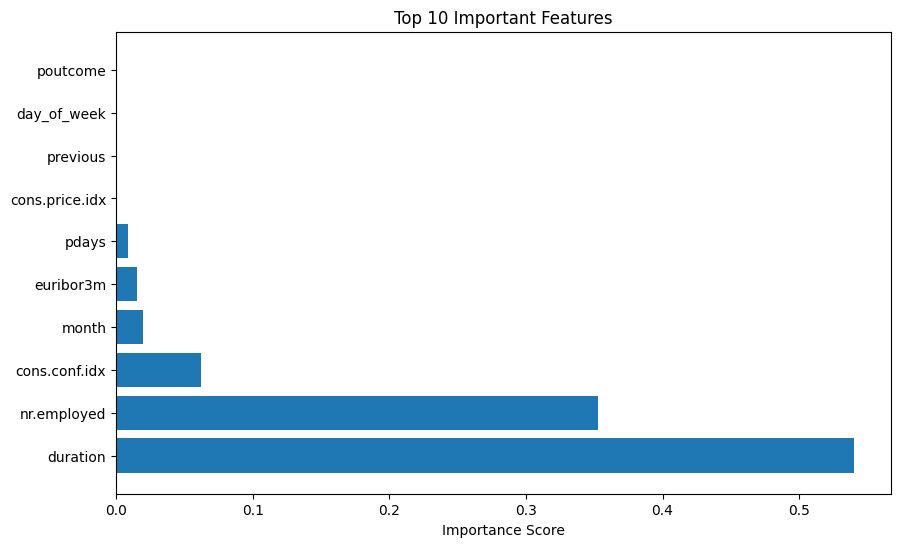

In [8]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_classifier.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Important Features:")
print(feature_importance.head(10))

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'][:10], feature_importance['Importance'][:10])
plt.title('Top 10 Important Features')
plt.xlabel('Importance Score')
plt.show()

# **5. Visualizing the Decision Tree**

---



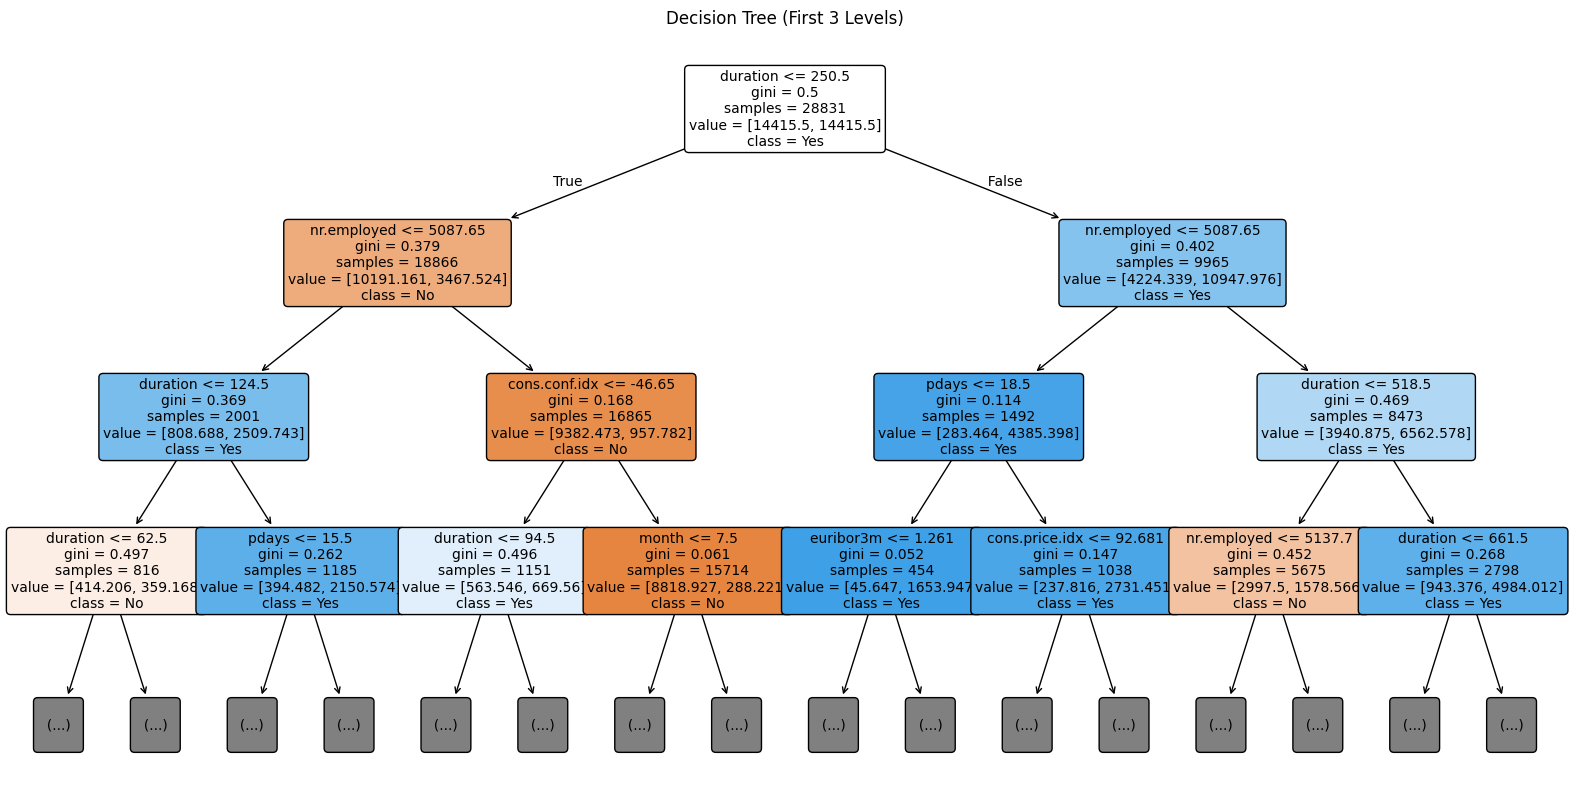

In [9]:
plt.figure(figsize=(20, 10))
plot_tree(
    dt_classifier,
    feature_names=X_train.columns,
    class_names=['No', 'Yes'],
    filled=True,
    rounded=True,
    max_depth=3,
    fontsize=10
)
plt.title("Decision Tree (First 3 Levels)")
plt.show()

# **6. Model Interpretation and Business Insights**

---



In [10]:
from sklearn.tree import _tree

def get_decision_paths(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []

    def recurse(node, depth, path):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            recurse(tree_.children_left[node], depth + 1, path + [(name, "<=", threshold)])
            recurse(tree_.children_right[node], depth + 1, path + [(name, ">", threshold)])
        else:
            paths.append((path, tree_.value[node]))

    recurse(0, 1, [])
    return paths

paths = get_decision_paths(dt_classifier, X_train.columns)
purchase_paths = [p for p in paths if p[1][0][1] > p[1][0][0]]
purchase_paths_sorted = sorted(purchase_paths, key=lambda x: x[1][0][1], reverse=True)[:5]

print("\nTop 5 Decision Paths Leading to Purchase:")
for i, (path, value) in enumerate(purchase_paths_sorted, 1):
    print(f"\nPath {i}:")
    print(f"Final node: {value[0]} samples (No: {value[0][0]}, Yes: {value[0][1]})")
    for step in path:
        print(f"{step[0]} {step[1]} {step[2]:.2f}")


Top 5 Decision Paths Leading to Purchase:

Path 1:
Final node: [0.02074255 0.97925745] samples (No: 0.020742546145944334, Yes: 0.9792574538540558)
duration <= 250.50
nr.employed > 5087.65
cons.conf.idx > -46.65
month > 7.50
duration > 83.00

Path 2:
Final node: [0.02349916 0.97650084] samples (No: 0.023499159259931908, Yes: 0.9765008407400692)
duration > 250.50
nr.employed <= 5087.65
pdays <= 18.50
euribor3m <= 1.26
poutcome > 1.00

Path 3:
Final node: [0.03148804 0.96851196] samples (No: 0.03148804130664663, Yes: 0.9685119586933536)
duration <= 250.50
nr.employed <= 5087.65
duration > 124.50
pdays <= 15.50
duration > 164.50

Path 4:
Final node: [0.04996209 0.95003791] samples (No: 0.04996209171755259, Yes: 0.9500379082824475)
duration > 250.50
nr.employed <= 5087.65
pdays <= 18.50
euribor3m <= 1.26
poutcome <= 1.00

Path 5:
Final node: [0.05932847 0.94067153] samples (No: 0.0593284680154457, Yes: 0.9406715319845562)
duration > 250.50
nr.employed <= 5087.65
pdays > 18.50
cons.price.id